In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

# Ближайшие соседи

В этом разделе мы разработаем метод классификации по ближайшим соседям.

## Хроническая болезнь почек
Рассмотрим пример. Мы собираемся работать с набором данных, который был собран, чтобы помочь врачам диагностировать хроническую болезнь почек (ХБП). Каждая строка в наборе данных представляет одного пациента, диагноз которого известен. Для каждого пациента у нас есть результаты анализов крови. Мы хотим узнать, какие показатели наиболее полезны для диагностики ХБП, и разработать способ классификации будущих пациентов как "Есть ХБП" или "Нет ХБП" на основе результатов анализа крови.

In [12]:
ckd = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/ckd.csv') \
                 .rename({'Blood Glucose Random': 'Glucose'}, axis=1)
ckd.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,1
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,29,12100,3.7,yes,yes,no,poor,no,yes,1
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,32,4500,3.8,yes,yes,no,poor,yes,no,1
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,16,11000,2.6,yes,yes,yes,poor,yes,no,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,1


Некоторые переменные относятся к категориям (например, "аномально"), другие являются количественными. Все количественные переменные имеют разные шкалы. Мы хотим выполнять сравнения и оценивать расстояния, как правило, на глаз, так что выберем всего несколько переменных и будем использовать стандартные единицы. Тогда нам не придется беспокоиться о шкале измерения каждой переменной.


In [13]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz) 

ckd[['Hemoglobin',
     'Glucose',
     'White Blood Cell Count']] = ckd[['Hemoglobin', 
                                       'Glucose',
                                       'White Blood Cell Count']].apply(standard_units)
ckd = ckd[['Hemoglobin',
           'Glucose',
           'White Blood Cell Count',
           'Class']]
ckd

,Hemoglobin,Glucose,White Blood Cell Count,Class
0,-0.865744,-0.221549,-0.569768,1
1,-1.457446,-0.947597,1.162684,1
2,-1.004968,3.841231,-1.275582,1
3,-2.814879,0.396364,0.809777,1
4,-2.083954,0.643529,0.232293,1
...,...,...,...,...
153,0.700526,0.133751,-0.569768,0
154,0.978974,-0.870358,-0.216861,0
155,0.735332,-0.484162,-0.601850,0
156,0.178436,-0.267893,-0.409356,0


Рассмотрим два столбца: уровень гемоглобина и уровень глюкозы в крови пациента (в случайное время дня, не на голодный желудок).

Нарисуем точечную диаграмму для визуализации связи между двумя переменными. Синие точки — пациенты с ХБП; золотые — без ХБП. Какие результаты анализов указывают на ХБП?

In [14]:
ckd['Color'] = ckd['Class'].map({1: 'darkblue', 0: 'gold'})

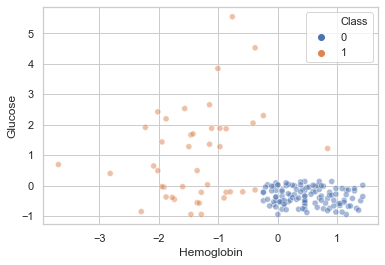

In [20]:
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', alpha=.5);

Предположим, Алиса — новый пациент, которого нет в наборе данных. Если знать уровень гемоглобина и глюкозы Алисы, можно ли спрогнозировать, есть ли у нее ХБП? Разумеется, можно! Вы видите четкую закономерность: точки в правом нижнем углу показывают людей, у которых нет ХБП, а у остальных есть эта болезнь. Человеку эта закономерность очевидна. Но как запрограммировать компьютер, чтобы он автоматически выявлял такие закономерности?

## Классификатор ближайших соседей
Существует множество типов закономерностей и алгоритмов классификации. Я расскажу об удивительно эффективном алгоритме. Он называется классификация по ближайшим соседям. Рассмотрим на примере. Если у нас есть показатели гемоглобина и глюкозы Алисы, мы можем разместить ее на графике: гемоглобин — это координата по оси x, а глюкоза — координата по оси y. Теперь, чтобы предсказать, есть ли у нее ХБП, можно найти ближайшую точку на диаграмме и посмотреть, синяя она или золотая. Мы предполагаем, что у Алисы тот же диагноз, что и у этого пациента.

Другими словами, чтобы классифицировать Алису по наличию ХБП, мы находим пациента в обучающем наборе, который находится ближе всего к Алисе, а затем основываем прогноз для Алисы на диагнозе этого пациента. Интуиция подсказывает, что, если две точки находятся рядом, у них схожие показатели, а значит, диагноз, скорее всего, будет одинаковым. Мы не знаем диагноз Алисы, но знаем диагноз всех пациентов в обучающем наборе, так что мы находим пациента, чьи показатели наиболее схожи с Алисиными, и на основе его диагноза предсказываем диагноз Алисы.

На приведенном ниже графика красная точка обозначает Алису. Она соединена черной линией с ближайшей к ней точкой, которая представляет ее ближайшего соседа в обучающем наборе. Рисунок создается с помощью функции `show_closest`. Она принимает массив, представляющий координаты $x$ и $y$ точки Алисы. Измените эти значения, чтобы увидеть, как меняется ближайшая точка. Обращайте особое внимание на цвет этой точки — синий или золотой.

In [28]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

In [67]:
HemoGl = ckd.drop(['White Blood Cell Count', 'Color', 'Class'], axis=1)
HemoGl['Distance'] = HemoGl.apply(lambda x: distance(x, alice), axis=1)
HemoGl.sort_values(by='Distance', inplace=True)
x_closest, y_closest = HemoGl.iloc[0][['Hemoglobin', 'Glucose']]
HemoGl.iloc[0][['Hemoglobin', 'Glucose']]

Hemoglobin   -0.030400
Glucose       0.087407
Name: 84, dtype: float64

In [68]:
def show_closest(point):
    """point = array([x,y])
    gives the coordinates of a new point
    shown in red"""

    HemoGl = ckd.drop(['White Blood Cell Count', 'Color', 'Class'], axis=1)
    HemoGl['Distance'] = HemoGl.apply(lambda x: distance(x, point), axis=1)
    HemoGl.sort_values(by='Distance', inplace=True)
    x_closest, y_closest = HemoGl.iloc[0][['Hemoglobin', 'Glucose']]
    sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', alpha=.5)
    plt.scatter(point[0], point[1], color='red', s=30, alpha=.5)
    plt.plot(np.array([point[0], x_closest]), np.array([point[1], y_closest]),
                                                                 color='b', lw=1.5);

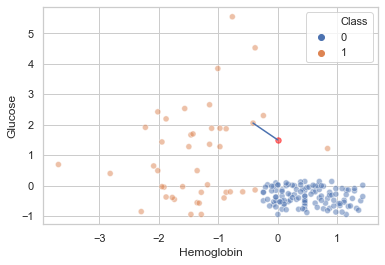

In [69]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = np.array([0, 1.5])
show_closest(alice)

Итак, наш классификатор по ближайшему соседу выглядит следующим образом:

- Найдите в обучающем наборе точку, ближайшую к новой точке.
- Если ближайшая точка входит в класс "Есть ХБП", отнесите новую точку к этому же классу.
- Если ближайшая точка входит в класс "Нет ХБП", отнесите новую точку к этому же классу.

Точечная диаграмма показывает, что классификатор по ближайшим соседям должен быть точным. Точки в правом нижем углу относятся к классу "Нет ХБП", так как их ближайший сосед — синяя точка. Остальные точки относятся к классу "Есть ХБП", так как их ближайший сосед — золотая точка. Так что стратегия ближайших соседей в этом примере сработала, как ожидалось.

## Граница принятия решений
Иногда полезно визуализировать классификатор в виде различных атрибутов, по которым классификатор определит класс "Есть ХБП", и атрибутам, которые указывают на класс "Нет ХБП". В итоге мы создадим некоторую границу между двумя классами. Точки по одну сторону границы будут классифицироваться как "Есть ХБП", а по другую — "Нет ХБП". Эта граница называется границей принятия решений. У каждого классификатора будет своя граница принятия решений. Граница принятия решений — это просто способ визуализации критериев, которые классификатор использует для классификации точек.

В первом примере точка Алисы имеет координаты (0, 1,5). Обратите внимание, что ближайший сосед является синим. Теперь попробуйте уменьшить высоту (координату $y$) точки. Вы увидите, что при $y=0,95$ ближайший сосед становится синим.

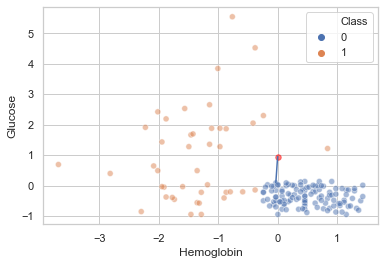

In [70]:
alice = np.array([0, 0.95])
show_closest(alice)

In [85]:
x_array = []
y_array = []
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array.append(x)
        y_array.append(y)

test_grid = pd.DataFrame(zip(x_array, y_array), columns=['Hemoglobin', 'Glucose'])

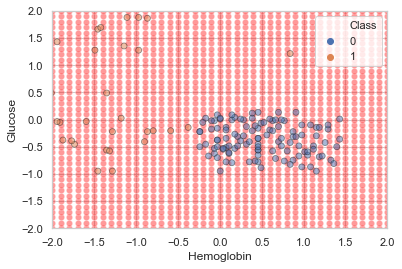

In [88]:
sns.scatterplot(data=test_grid, x='Hemoglobin', y='Glucose', color='red', alpha=0.4, s=40)
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', edgecolor='k', alpha=0.5)

plt.xlim(-2, 2)
plt.ylim(-2, 2);

Каждая из красных точек имеет ближайших соседей в обучающем наборе (те же синие и золотые точки, что и раньше). Для некоторых красных точек можно легко определить, является ли ближайший сосед синим или золотым. Для других это сложно определить на глаз. Это точки, близкие к границе принятия решений.

Но компьютер может легко определить ближайшего соседа каждой точки. Попробуем применить классификатор по ближайшему соседу к каждой красной точке:

Для каждой красной точки нужно найти ближайшую точку в обучающем наборе. Затем она изменит свой цвет на цвет ближайшего соседа.

На получившемся графике видно, какие точки попали в класс "Есть ХБП" (золотые), а какие — в класс "Нет ХБП" (синие).

In [ ]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def classify_grid(training, test, k):
    c = make_array()
    for i in range(len(test)):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c